# Info

Implementation of Deep Q-Network (DQN) in Tensorflow 2.0+.

Uses the implementation of DQN with just the replay memory (no target memory) with bootstrap learning



Resources:
* Original DQN paper [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

* PyTorch [REINFORCEMENT LEARNING (DQN) TUTORIAL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

* [tensorflow.org RL - Intro](https://www.tensorflow.org/agents/tutorials/0_intro_rl)

* [philtabor/Youtube-Code-Repository](https://github.com/philtabor/Youtube-Code-Repository)

* [shivaverma/OpenAIGym](https://github.com/shivaverma/OpenAIGym)

In [1]:
# from pyglet.gl import *
# import gym
# from IPython import display
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline

# env = gym.make('CartPole-v0')
# env.reset()
# env.render(mode='rgb_array')

In [2]:
# try:
#     import Image
# except ImportError:
#     from PIL import Image
# import gym
# from IPython import display

# env = gym.make('Breakout-v0')
# array = env.reset()
# frame = PIL.Image.fromarray(env.render(mode='rgb_array'))
# display.display(frame)

# for _ in range(1000):
#     action = env.action_space.sample()
#     frame = PIL.Image.fromarray(env.render(mode='rgb_array'))
#     display.display(frame)
#     display.clear_output(wait=True)
#     env.step(action)

# Imports

In [3]:
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

# disable eager execution to speed up
tf.compat.v1.disable_eager_execution()
np.random.seed(0)

tf.__version__

'2.2.0'

# Helper Functions

## Replay Buffer

In [4]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        """Also called 'Replay Memory' it's designed to store previous
            observation, action, reward, next-observation values.
         The DQN needs experience replay to reduce correlations in 
             the sequence of observations, which otherwise might drive 
             the network into a local minimum.
        """
        # when buffer gets full it goes back and re-writes again
        self.mem_size = max_size
        # position of first unsaved memory
        self.mem_cntr = 0
        self.discrete = discrete
        self.observation_memory = np.zeros((self.mem_size, input_shape))
        self.new_observation_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        # keep track of our `done` flags becuase the value of the terminal state is 0.
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def collect_experience(self, state, action, reward, state_, done):
        """ Populate the replay memory with initial experience.
        """
        index = self.mem_cntr % self.mem_size
        self.observation_memory[index] = state
        self.new_observation_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        # when episode done is 'True'. Use this to multiple the reward.
        #  If reached temrinal state we don't give any reward (reward 0)
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        """Sample memory buffer."""
        max_mem = min(self.mem_cntr, self.mem_size)
        # replace will detemrine if reuse examples if already sampled
        batch = np.random.choice(max_mem, batch_size, replace=False)

        observations = self.observation_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_observations = self.new_observation_memory[batch]
        terminal = self.terminal_memory[batch]

        return observations, actions, rewards, new_observations, terminal


## DQN Agent

In [5]:
class DqnAgent(object):
    def __init__(self, online_model, n_actions, input_dims, gamma=1, epsilon_start=0.9, epsilon_dec=0.996, epsilon_end=0.01, batch_size=32,
                 replay_buffer_max_length=10000, fname='dqn_model.h5'):
        """Creat DQN Agent.
        
        Args:
            online_model : TF model used for training.
                        
            gamma : Discount factor (0-1 value). It makes rewards from the uncertain 
                far future less important for our agent than the ones in the near 
                future that it can be fairly confident about.
                
            n_actions : Number of actions of environment.
            
            epsilon : Epsilon-greedy method for exploration.
            
            batch_size : Size of batch for Neural Network model training batch. Also used
                in the memory replay, returning batch size of data.
                
            input_dim : Dimension of environment state.
            
            epsilon_dec : Decay for epislon. It starts with large value and it decays 
                to a minimum value. It performs more exploration at beginning of train.
                
            epsilon_end : Minimum value for epsilon. It is useful to keep a minimum value 
                of epsilon to encourage exploration durign training even after epsilon 
                finished decay.
                
            replay_buffer_max_length : Number of examples to store in memory that is used for 'memory replay'.
            
            fname : File name to save model.
            
        NOTE: 
            - This implementation can handle only tensorflow 2.0+.
            - This implementaiton does not contain a target model which gets updated along training.
        """
        self.action_space = list(range(n_actions))
        self.gamma = gamma
        self.epsilon = float(epsilon_start)
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(replay_buffer_max_length, input_dims, n_actions,
                                   discrete=True)
        # online model used for training
        self.online_model = online_model
        # target model used as policy
        self.target_model = tf.keras.models.clone_model(online_model)
        
    def collect_experience(self, observation, actions, rewards, new_observations, terminal):
        self.memory.collect_experience(observation, actions, rewards, new_observations, terminal)
        return

    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
        random_transition = np.random.uniform()
        if random_transition < self.epsilon:
            # perform exploration (random choice action)
            action = np.random.choice(self.action_space)
        else:
            # perform exploitation (use current policy)
            actions = self.target_model.predict(observation)
            # return action value
            action = np.argmax(actions)

        return action
    
    def policy(self, observation):
        """Policy should handle observations and return best action.
        Make sure observation is input of batch 1.
        """
        
        # expand dimension of observation if first shape is not 1
        observation = np.expand_dims(observation, axis=0) \
                        if observation.shape[0]!=1 else observation
        # perform exploitation (use current policy)
        actions = self.target_model.predict(observation)
        # return action value
        action = np.argmax(actions)
        return action
        

    def train(self):
        if self.memory.mem_cntr > self.batch_size:
            # fill out at least batch size memory
            observation, action, reward, new_observation, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            # from one-hot to indeces
            action_indices = np.dot(action, action_values)
            
            # use target model as policy
            q_eval = self.target_model.predict(observation)
            # make copy in order to change it later
            q_target = q_eval.copy()
            # get Q-values for new observation
            q_next = self.target_model.predict(new_observation)
            
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            # create Q-values. No reward for ending states.
            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done
            # fit batch to online-model
            _ = self.online_model.fit(observation, q_target, verbose=0)
            
            # update epsilon
            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_end else self.epsilon_end
            
#             self.epsilon = (self.epsilon - self.epsilon_dec) if self.epsilon > \
#                            self.epsilon_end else self.epsilon_end
        return
            
    def update_policy(self):
        """Update target-network.
        """
        self.target_model.set_weights(self.online_model.get_weights())
        return
    
    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = tf.keras.models.load_model(self.model_file)

## Functions

In [6]:
def encode_observation(observation_size, observation):
    if type(observation) != np.ndarray and observation <= observation_size:
        # need to perform one-hot encoding
        encoded_observation = np.zeros(observation_size)
        encoded_observation[observation] = 1
        return encoded_observation
    elif len(observation) == observation_size:
        return observation
    else:
        raise NameError('Observation size %s does not match environment \
                        observation size! %s' % (observation_size, len(observation)))
        return

def compute_avg_return(environment, observation_size, policy, num_episodes=10):
    """Evaluate Agent on Test environment.
    """
    
    total_return = 0.0
    for _ in range(num_episodes):
        finished_episode = False
        observation = environment.reset()
        observation = encode_observation(observation_size, observation)
        episode_return = 0.0
        while not finished_episode:
            # take action
            action = policy(observation)
            # update trajectories
            new_observation, reward, finished_episode, info = environment.step(action)
            new_observation = encode_observation(observation_size, new_observation)
            # keep track of reward
            episode_return += reward
            # update observation
            observation = new_observation
        # end of episode
        total_return += episode_return
    # return mean of cumulated reward from each episode
    return total_return / num_episodes

# Hyperparameters

In [7]:
learning_rate = 5e-4
batch_size = 63
num_iterations = 15000
policy_updates = 100
epsilon_start = 1
epsilon_dec = 0.999
epsilon_end = 0.01
gamma = 0.99
replay_buffer_max_length  = int(1e5)  
num_eval_episodes = 10
eval_interval = 200


environment_name = 'FrozenLake-v0'#'LunarLander-v2'#"CartPole-v0"#"FrozenLake-v0"

train_environment = gym.make(environment_name)
evaluate_environment = gym.make(environment_name)

train_environment.seed(0)
evaluate_environment.seed(0)

n_actions = train_environment.action_space.n
observation_size = train_environment.observation_space.shape[0] \
                    if train_environment.observation_space.shape \
                    else train_environment.observation_space.n

# create tf model
model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, input_shape=(observation_size,), activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(n_actions, activation='linear')])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='mse')

# create DQN agent
agent = DqnAgent(online_model=model, 
                 n_actions=n_actions, 
                 input_dims=observation_size,
                 gamma=gamma, 
                 epsilon_start=epsilon_start, 
                 epsilon_dec=epsilon_dec, 
                 epsilon_end=epsilon_end, 
                 batch_size=batch_size, 
                 replay_buffer_max_length=replay_buffer_max_length, 
                 fname=None)

# show tf model structure
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 2,916
Trainable params: 2,916
Non-trainable params: 0
_________________________________________________________________


# Train

In [8]:
average_return = {"iteration":[],
                 "average_return":[],
                 }
epsilons = []
iteration = 0


# evaluate the agent's policy once before training.
avg_return = compute_avg_return(evaluate_environment, observation_size, agent.policy, num_eval_episodes)
average_return['iteration'].append(iteration)
average_return['average_return'].append(avg_return)
num_episodes = 0

while iteration < num_iterations:
    finished_episode = False
    
    observation = train_environment.reset()
    observation = encode_observation(observation_size, observation)
    
    while (not finished_episode) and (iteration < num_iterations):
        # take action
        action = agent.choose_action(observation)
        # update trajectories
        new_observation, reward, finished_episode, info = train_environment.step(action)
        new_observation = encode_observation(observation_size, new_observation)
        # colelct experience
        agent.collect_experience(observation, action, reward, new_observation, int(finished_episode))
        # update observation
        observation = new_observation
        # train on-line model
        agent.train()
        
        # update policy
        if iteration % policy_updates == 0:
            agent.update_policy()

        # evaluate model
        if (iteration+1) % eval_interval  == 0:
            avg_return = compute_avg_return(evaluate_environment, observation_size, agent.policy, num_eval_episodes)
            
            average_return['iteration'].append(iteration)
            average_return['average_return'].append(avg_return)
            print('Iteration {} Episodes {} Average Return {:.2f} Epsilon {:.3f}'.format(iteration+1,
                                                                                         num_episodes,
                                                                        avg_return, 
                                                                        agent.epsilon))
        # keep track of epsilon
        epsilons.append(agent.epsilon)
        # next iteration
        iteration += 1
        
    # end of episode
    num_episodes += 1

Iteration 200 Episodes 26 Average Return 0.10 Epsilon 0.872
Iteration 400 Episodes 47 Average Return 0.00 Epsilon 0.714
Iteration 600 Episodes 67 Average Return 0.20 Epsilon 0.584
Iteration 800 Episodes 89 Average Return 0.10 Epsilon 0.478
Iteration 1000 Episodes 112 Average Return 0.20 Epsilon 0.392
Iteration 1200 Episodes 132 Average Return 0.10 Epsilon 0.321
Iteration 1400 Episodes 152 Average Return 0.20 Epsilon 0.262
Iteration 1600 Episodes 164 Average Return 0.20 Epsilon 0.215
Iteration 1800 Episodes 178 Average Return 0.00 Epsilon 0.176
Iteration 2000 Episodes 186 Average Return 0.50 Epsilon 0.144
Iteration 2200 Episodes 193 Average Return 0.30 Epsilon 0.118
Iteration 2400 Episodes 205 Average Return 0.30 Epsilon 0.097
Iteration 2600 Episodes 212 Average Return 0.40 Epsilon 0.079
Iteration 2800 Episodes 219 Average Return 0.40 Epsilon 0.065
Iteration 3000 Episodes 222 Average Return 0.30 Epsilon 0.053
Iteration 3200 Episodes 231 Average Return 0.60 Epsilon 0.043
Iteration 3400 E

# Plot

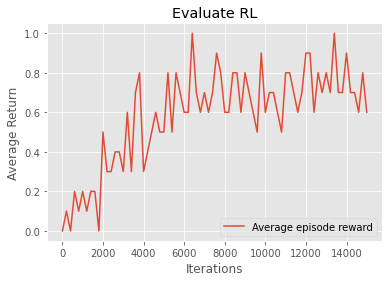

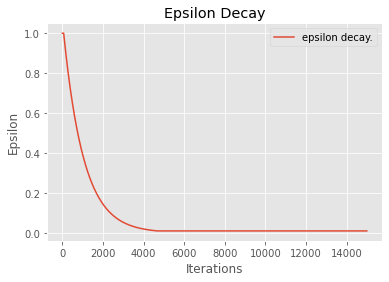

In [9]:
plt.figure()
plt.title('Evaluate RL')
plt.plot(average_return['iteration'], average_return['average_return'], label="Average episode reward")
plt.xlabel('Iterations')
plt.ylabel('Average Return')
plt.legend()

plt.figure()
plt.title('Epsilon Decay')
plt.plot(epsilons, label="epsilon decay.")
plt.xlabel('Iterations')
plt.ylabel('Epsilon')
plt.legend()
plt.show()